# Political Toxicity: Conventional NLP Pipelines
Using Apache Spark, the project should be able to take in CSV data from social media posts and classify them accurately as toxic or not.

In [128]:
from pyspark.sql import SparkSession, functions as F, types as T
from pyspark.sql import DataFrame
spark = SparkSession.builder.appName('Test').getOrCreate()

In [129]:
from pyspark.sql.functions import col, trim, lower, when
"""
Maps the column from string values to double values.
0.0 in all unknown types or cases
"""
def map_toxic_hard(df, col_name="toxic_hard", new_col="toxic_score"):
    return df.withColumn(
        new_col,
        when(trim(lower(col(col_name))) == "true", 1)   # string TRUE
        .when(trim(lower(col(col_name))) == "false", 0) # string FALSE
        .otherwise(0)                                   # everything else
    )

def preprocessing_steps(df: DataFrame) -> DataFrame:
    temp = map_toxic_hard(df, "toxic_hard", "toxic_score")
    return temp.select('text','toxic_score') \
        .dropna(subset=['text'])

"""
Reads the CSV containing the training data at the given path 
and returns a spark dataframe.
"""
def read_train_data(path:str) -> DataFrame:
    seed_df = (
        spark.read
            .option("header", True)
            .option("inferSchema", True)
            .option("multiline", True)
            .csv(path,sep=',',ignoreLeadingWhiteSpace=True,ignoreTrailingWhiteSpace=True)
    )
    seed_df = preprocessing_steps(seed_df)
    return seed_df

In [130]:
train_data_path = "data/train/dataset.csv"
seed_df = read_train_data(train_data_path)

## Data Cleaning and Preparation

For all the tweets we need to remove all tokens that are not useful to the analysis. Then we need to create simple lists of relevant tokens for the unsupervised BERT model to identify.

In [131]:
seed_df.printSchema()

root
 |-- text: string (nullable = true)
 |-- toxic_score: integer (nullable = false)



In [132]:
# Import the libraries we need
from pyspark.ml import Pipeline
from pyspark.sql import DataFrame
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.feature import HashingTF
from pyspark.ml.classification import LogisticRegression

#from pyspark.ml import Transformer
#from pyspark.sql import DataFrame
from pyspark.sql.functions import col

In [133]:
# Pipeline builder

# ETL
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol='cleaned_words')

# Hash/Vectorize
hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol='features')

# Regression Estimation
lr = LogisticRegression(featuresCol='features',labelCol='toxic_score',
        maxIter=10, regParam=0.001)

# Pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, lr])

In [134]:
# Check whether the GPU is open
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
NVIDIA T500


In [135]:
""" DEBUG
# Print out all parameters for this stage
print("LogisticRegression parameters:")
print(lr.explainParams())
# If you want to check just the labelCol and featuresCol:
print("Label column:", lr.getLabelCol())
print("Features column:", lr.getFeaturesCol())
"""
# Now fit only on the required columns
model = pipeline.fit(seed_df)
model

PipelineModel_246d53add9dc

## Predict on Test Data
This will load a small test subset and confirm our predictions are correct.

In [136]:
test_path = "data/test/2pt_test.csv"

test_df = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .csv(test_path)
)

In [137]:
test_df.printSchema()

root
 |-- text: string (nullable = true)
 |-- toxic_score_true: double (nullable = true)



In [138]:
predictions = model.transform(test_df)
predictions.select('toxic_score_true','prediction','probability').show(truncate=False)

+----------------+----------+------------------------------------------+
|toxic_score_true|prediction|probability                               |
+----------------+----------+------------------------------------------+
|0.0             |0.0       |[0.9985773268381002,0.0014226731618998123]|
|1.0             |1.0       |[9.038140940731217E-5,0.9999096185905927] |
+----------------+----------+------------------------------------------+



In [139]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
SEED = 22

In [140]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol='cleaned_words')
hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol='features')
lr = LogisticRegression(featuresCol='features',labelCol='toxic_score',
        maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[tokenizer,remover,hashingTF,lr])

In [141]:
grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
evaluator = BinaryClassificationEvaluator(labelCol='toxic_score')
tvs = TrainValidationSplit(
    estimator=pipeline,parallelism=10,
    seed=SEED,
    evaluator=evaluator,
    estimatorParamMaps=grid)
train_df = read_train_data(train_data_path)

model = tvs.fit(train_df)
model.bestModel.transform(dataset=test_df)\
    .select('toxic_score_true','probability','prediction')\
    .show(truncate=False)
    # 'probability' represents the 1/P probability of that class 
    # being the predicted class of this document.
    


+----------------+-----------------------------------------+----------+
|toxic_score_true|probability                              |prediction|
+----------------+-----------------------------------------+----------+
|0.0             |[0.8884556385439323,0.11154436145606772] |0.0       |
|1.0             |[0.031650691973346586,0.9683493080266534]|1.0       |
+----------------+-----------------------------------------+----------+



In [142]:
model.validationMetrics
# represents ROC AUC for each parameter setting tuple in the grid

[0.5, 0.6995571644466337]

### McNemar's Test

Compares where models differ in classification to determine if there is a signifcant difference between them. If for example they both classify the same amount incorrectly then obviously there is no significant difference, but if one model is technically more accurate but they agree on most of the classifications, then the data will show the result is not significant enough to disprove the null hypothesis.

In [143]:
# Split data 80/20
test_fraction = 0.2
train, test = train_df.randomSplit([1-test_fraction, test_fraction], 
                                           seed=0)

In [144]:
# Basic model metrics

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col

def display_metrics(predictions):
    # Assume 'predictions' DataFrame has:
    #   - 'label' (0 or 1)
    #   - 'prediction' (0 or 1)
    #   - 'probability' (vector of probabilities, needed for ROC/AUC)

    # --- Accuracy ---
    acc_eval = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy"
    )
    accuracy = acc_eval.evaluate(predictions)
    print("Accuracy Score:", accuracy)

    print("--------------------------------------------------------")

    # --- Confusion Matrix ---
    confusion = predictions.groupBy("label", "prediction").count().orderBy("label", "prediction")
    confusion.show()
    print("--------------------------------------------------------")

    # --- Precision, Recall, F1 ---
    prec_eval = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="weightedPrecision"
    )
    rec_eval = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="weightedRecall"
    )
    f1_eval = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="f1"
    )

    precision = prec_eval.evaluate(predictions)
    recall = rec_eval.evaluate(predictions)
    f1 = f1_eval.evaluate(predictions)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    print("--------------------------------------------------------")

    # --- ROC AUC ---
    auc_eval = BinaryClassificationEvaluator(
        labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC"
    )
    roc_auc = auc_eval.evaluate(predictions)
    print("ROC_AUC Score:", roc_auc)

    return (accuracy,precision,recall,f1,roc_auc)


In [145]:
# Instantiate DataFrame
text_col = 'text'
label_col = 'toxic_score'

In [146]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, Word2Vec
# Preprocessing steps for all pipelines
tokenizer = Tokenizer(inputCol=text_col, outputCol="words")
filter = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol='filtered_words')

In [147]:
# TF-IDF model
hashing_tf = HashingTF(inputCol=filter.getOutputCol(), outputCol='raw_features')
idf = IDF(inputCol=hashing_tf.getOutputCol(), outputCol="features")
lr_tfidf = LogisticRegression(featuresCol=idf.getOutputCol(), labelCol=label_col,
        maxIter=10, regParam=0.001)

pipeline_tfidf = Pipeline(stages=[tokenizer,filter,hashing_tf,idf,lr_tfidf])

In [148]:
# Fit and predict on whole corpus (no holdout)
model_tfidf = pipeline_tfidf.fit(train)
prediction_raw = model_tfidf.transform(test)
pred_tfidf = prediction_raw.select(text_col, label_col, col("prediction").alias("pred_tfidf"))
pred_tfidf.head(5)

[Row(text='"""Non-islamic countries""', toxic_score=0, pred_tfidf=0.0),
 Row(text='"""Now go', toxic_score=0, pred_tfidf=0.0),
 Row(text='"""Vaccines may get authorized for young kids in October."" https://www.businessinsider.com/when-can-young-kids-get-vaccinated-timeline-2021-7"', toxic_score=0, pred_tfidf=0.0),
 Row(text='"""Well', toxic_score=0, pred_tfidf=0.0),
 Row(text='"""What a nightmare""    why not bring back the troop before we pulled out incompetent decisione bless the innocent"', toxic_score=0, pred_tfidf=0.0)]

In [149]:
# Metrics Word2Vec
metrics_tfidf = display_metrics(prediction_raw.select(col(label_col).alias('label'), col('prediction'), col('probability')))

Accuracy Score: 0.7875166002656042
--------------------------------------------------------
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|  572|
|    0|       1.0|   67|
|    1|       0.0|   93|
|    1|       1.0|   21|
+-----+----------+-----+

--------------------------------------------------------
Precision: 0.7660566210891228
Recall: 0.7875166002656042
F1 Score: 0.7759602421269185
--------------------------------------------------------
ROC_AUC Score: 0.6655204129258995


In [150]:
# Word2Vec model
word2vec = Word2Vec(vectorSize=100, minCount=0, inputCol=filter.getOutputCol(), outputCol="features")
lr_w2v = LogisticRegression(featuresCol=word2vec.getOutputCol(), labelCol=label_col)
pipeline_w2v = Pipeline(stages=[tokenizer, filter, word2vec,lr_w2v])

In [151]:
# Fit and predict on WHOLE corpus (no holdout)
model_w2v = pipeline_w2v.fit(train)
prediction_raw = model_w2v.transform(test)
pred_w2v = prediction_raw.select(text_col, label_col, col("prediction").alias("pred_w2v"))
pred_w2v.head(5)

[Row(text='"""Non-islamic countries""', toxic_score=0, pred_w2v=0.0),
 Row(text='"""Now go', toxic_score=0, pred_w2v=0.0),
 Row(text='"""Vaccines may get authorized for young kids in October."" https://www.businessinsider.com/when-can-young-kids-get-vaccinated-timeline-2021-7"', toxic_score=0, pred_w2v=0.0),
 Row(text='"""Well', toxic_score=0, pred_w2v=0.0),
 Row(text='"""What a nightmare""    why not bring back the troop before we pulled out incompetent decisione bless the innocent"', toxic_score=0, pred_w2v=0.0)]

In [152]:
# Metrics Word2Vec
metrics_w2v=display_metrics(prediction_raw.select(col(label_col).alias('label'), col('prediction'), col('probability')))

Accuracy Score: 0.8472775564409031
--------------------------------------------------------
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|  637|
|    0|       1.0|    2|
|    1|       0.0|  113|
|    1|       1.0|    1|
+-----+----------+-----+

--------------------------------------------------------
Precision: 0.7712138114209828
Recall: 0.8472775564409031
F1 Score: 0.7809345954131822
--------------------------------------------------------
ROC_AUC Score: 0.5996417099085735


In [153]:
! pip install statsmodels

In [154]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

combined = pred_tfidf.join(pred_w2v, on=[text_col, label_col])
# Convert to numpy arrays
from pyspark.sql.functions import col

# contingency counts directly with boolean masks
n11 = combined.filter((col("pred_tfidf") == col(label_col)) & (col("pred_w2v") == col(label_col))).count()
n10 = combined.filter((col("pred_tfidf") == col(label_col)) & (col("pred_w2v") != col(label_col))).count()
n01 = combined.filter((col("pred_tfidf") != col(label_col)) & (col("pred_w2v") == col(label_col))).count()
n00 = combined.filter((col("pred_tfidf") != col(label_col)) & (col("pred_w2v") != col(label_col))).count()

table = [[n11, n10],
         [n01, n00]]
print("Contingency Table:", table)

# --- McNemar’s test ---
result = mcnemar(table, exact=True)
print(f"Statistic={result.statistic}, p-value={result.pvalue}") # type: ignore

Contingency Table: [[571, 22], [67, 93]]
Statistic=22.0, p-value=1.899849174722082e-06


X^2 (statistic) = (b-c)^2 / b + c <br>
The ratio squared difference between disagreed negatives and positives to the sum of the number of disagreements.

|x|Test 2 positive|	Test 2 negative	|Row total|
|---------------|-------------------|---------|--------|
|Test 1 positive|  a  |  b  |  a + b  |
|Test 1 negative|  c  |  d  |  c + d  |
|Column total   |  a + c  |  b + d  |  N  |



||||
|-------|------|------|
| Null Hypothesis | H0 | p(b) = p(c) |
| Alt Hypothesis | H1 | p(b) =/= p(c) |

### Paired t-test
Using 5x2 fold validation.

In [155]:
! pip install mlxtend

In [156]:
def make_splits(df, n_splits=5, test_fraction=0.5):
    splits = []
    for i in range(n_splits):
        # Randomize order each time
        train, test = train_df.randomSplit([1-test_fraction, test_fraction], 
                                           seed=i)
        splits.append((train, test))
        # Swap train/test for the "×2" part
        splits.append((test, train))
    return splits


In [157]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="toxic_score", predictionCol="prediction", metricName="accuracy"
)

diffs = []
splits = make_splits(train_df, n_splits=5)

for train_split, test_split in splits:
    # Fit both models
    modelA = pipeline_tfidf.fit(train_split)
    modelB = pipeline_w2v.fit(train_split)

    # Predict
    predA = modelA.transform(test_split)
    predB = modelB.transform(test_split)

    # Evaluate accuracy
    accA = evaluator.evaluate(predA)
    accB = evaluator.evaluate(predB)
    print("Accuracies (tfidf,w2v):", accA, accB)

    # Store difference
    diffs.append(accA - accB)


Accuracies (tfidf,w2v): 0.7905817174515235 0.8365650969529086
Accuracies (tfidf,w2v): 0.7944664031620553 0.8266516092603049
Accuracies (tfidf,w2v): 0.7911111111111111 0.8305555555555556
Accuracies (tfidf,w2v): 0.7843468468468469 0.8305180180180181
Accuracies (tfidf,w2v): 0.7986614612381484 0.8388176240936978
Accuracies (tfidf,w2v): 0.7779024116657319 0.8222097588334268
Accuracies (tfidf,w2v): 0.7878453038674034 0.8287292817679558
Accuracies (tfidf,w2v): 0.7967157417893544 0.8278595696489242
Accuracies (tfidf,w2v): 0.8047138047138047 0.8417508417508418
Accuracies (tfidf,w2v): 0.7926421404682275 0.8199554069119287


In [158]:
import numpy as np
from math import sqrt

diffs = np.array(diffs)
mean_diff = diffs.mean()
std_diff = diffs.std(ddof=1)
n = len(diffs)

t_stat = mean_diff / (std_diff / sqrt(n))

# Two‑sided p‑value (using scipy if allowed, or approximate)
from scipy.stats import t
p_val = 2 * (1 - t.cdf(abs(t_stat), df=n-1))

alpha = 0.05
print(f"t statistic: {t_stat:.3f}")
print(f"p value: {p_val:.3f}")
print("Reject null hypothesis" if p_val < alpha else "Fail to reject null hypothesis")


t statistic: -18.739
p value: 0.000
Reject null hypothesis


### Q + A 
Here's some observations I made while testing these models. I confirmed my suspicions after consulting Copilot and Google sources on the matter as well as my own background knowledge.

**Why do you use multiclass classification evaluator for the accuracy score?** <br>
In PySpark, the binary classifier I have developed is essentially treated as a multiclass classifier for the purposes of accessing the accuracy, f1, precision, and recall scores, 

**Why not do more than 5 splits for the 5x2 test?** <br>
The originator of the framework determined that 5x2 is the best version because it creates enough observations for a t test to be valuable. And, if we did any more it might make the features sort of colinear which biases the results and always makes them significant. (therefore lending to type 1 error)

**Why does the McNemar test show no significance?** <br>
Tf-IDF outperforms Word2Vec in a case where the training dataset is equivalent to the test dataset because the features are dead even and the hashing function captured them all. Word2Vec performs better on less training information because *similar* words will still be classed together, unlike under Tf-IDF as a kind of Counting vectorizer.

**How should we interpret the McNemar test versus the t-test?**
1. Reject the McNemar test. It is not useful because one model structurally outperforms in that particular situation. I needed to perform a data holdout. The test is functionally invalid because it is structurally unsound.
2. Accept the t-test. It is better representative of the data situation and cross validation provides more observations than the McNemar test.
3. Reject McNemar becaues it only focuses on significant disagreement but does not compare agreement. That means where there are drastic differences between two models, the test tends to fail. Also if they generally agree on the same points but equally disagree on the same points, then the test comes out as a wash. This may be useful in some cases but this would not happen in a t test with cross validation. McNemar is useful, just not the way I performed it.

In [159]:
# Generate Visualizations for Data Comparison
# Convert to dataframe
#  return (accuracy,confusion,precision,recall,f1,roc_auc)
import pandas as pd
metrics_tfidf_df = pd.DataFrame({
    'model': 'Tf-IDF',
    'Acc': metrics_tfidf[0],
    'Precision': metrics_tfidf[1],
    'Recall': metrics_tfidf[2],
    'f1': metrics_tfidf[3],
    'roc_auc': metrics_tfidf[4]
}, index=[0])
metrics_w2v_df = pd.DataFrame({
    'model': 'w2v',
    'Acc': metrics_w2v[0],
    'Precision': metrics_w2v[1],
    'Recall': metrics_w2v[2],
    'f1': metrics_w2v[3],
    'roc_auc': metrics_w2v[4]
},  index=[1])
metrics = pd.concat([metrics_tfidf_df,metrics_w2v_df])
metrics


,model,Acc,Precision,Recall,f1,roc_auc
0,Tf-IDF,0.787517,0.766057,0.787517,0.775960,0.665520
1,w2v,0.847278,0.771214,0.847278,0.780935,0.599642


In [160]:
! pip install matplotlib

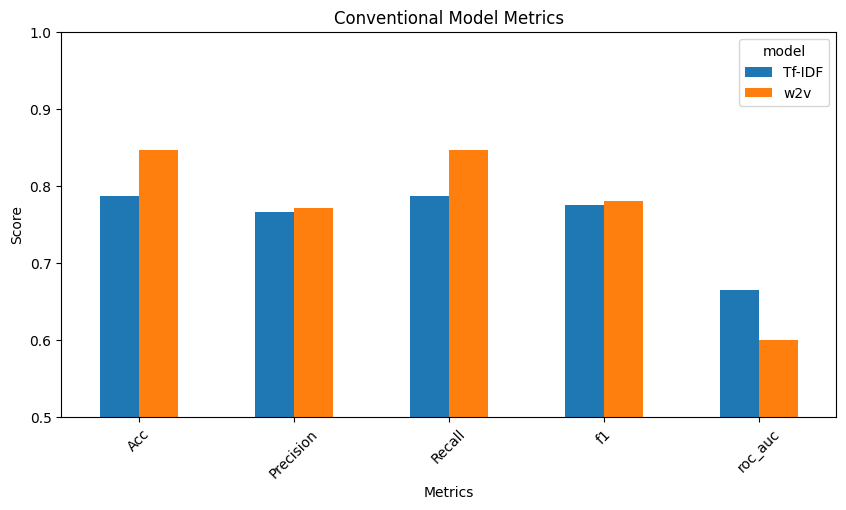

In [183]:
import matplotlib.pyplot as plt

ax = metrics.groupby(by='model').sum().T.plot(kind='bar',figsize=(10,5));

# Set custom y-axis limits
y_min = 0.5
y_max = 1
ax.set_ylim(y_min, y_max)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title("Conventional Model Metrics")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.savefig('Conventional_metrics_1_test.png',bbox_inches="tight")